In [4]:
import torch
import os
import sys
sys.path.append('..')
from models.resnet import resnet8
from models.lenet import LeNet
from data_preprocessing.cifar10.data_loader import (
            get_client_dataloader, get_client_idxes_dict)

In [2]:
import autograd_hacks

In [11]:
print(os.listdir('/mnt/data/th/FedTH/data/dataset'))

['cininc.tar.gz', 'cinic10_tar', 'emnist', 'cinic10', 'covid_tar', 'femnist', 'cifar100', 'imagenet', 'covtype', 'covid', 'covid.tar.gz', 'mnist', 'celeba', 'cifar10', 'svhn', 'covid19-radiography-database.zip']


In [8]:
dict_client_idexes, class_num, client_infos = get_client_idxes_dict('/mnt/data/th/FedTH/data/dataset/cifar10', "hetero", 0.3, 20)
print(client_infos)

INFO:root:*********partition data***************
INFO:root:N = 50000
INFO:root:traindata_cls_counts = {0: {0: 531, 1: 12, 2: 24, 3: 34, 4: 11, 6: 1272, 7: 6, 8: 138, 9: 313}, 1: {0: 27, 1: 909, 2: 170, 3: 27, 4: 1109, 6: 1143}, 2: {0: 307, 2: 220, 3: 63, 4: 394, 5: 104, 6: 176, 7: 376, 8: 733, 9: 8}, 3: {0: 1094, 1: 1, 2: 333, 3: 65, 4: 1041}, 4: {0: 222, 1: 61, 2: 258, 3: 3, 4: 1158, 5: 10, 6: 320, 7: 303, 8: 184}, 5: {0: 1, 2: 107, 3: 47, 6: 277, 8: 1871}, 6: {0: 12, 1: 3, 2: 42, 3: 63, 4: 414, 5: 2149}, 7: {0: 106, 1: 220, 2: 183, 3: 690, 4: 106, 5: 366, 6: 19, 8: 10, 9: 34}, 8: {1: 1, 2: 386, 3: 77, 4: 582, 5: 75, 7: 1, 8: 503, 9: 567}, 9: {0: 1, 1: 294, 2: 4, 3: 933, 4: 79, 5: 132, 6: 4, 7: 66, 8: 9, 9: 418}, 10: {0: 2, 3: 43, 5: 922, 6: 218, 8: 19, 9: 540}, 11: {1: 31, 2: 487, 3: 74, 4: 1, 5: 215, 7: 1051, 8: 18, 9: 1883}, 12: {0: 2288, 1: 1748}, 13: {0: 2, 1: 883, 2: 550, 3: 241, 4: 20, 5: 3, 6: 104, 7: 1, 8: 27, 9: 327}, 14: {1: 29, 2: 2, 3: 31, 5: 215, 6: 984, 7: 20, 8: 728, 9

{0: {0: 531, 1: 12, 2: 24, 3: 34, 4: 11, 6: 1272, 7: 6, 8: 138, 9: 313}, 1: {0: 27, 1: 909, 2: 170, 3: 27, 4: 1109, 6: 1143}, 2: {0: 307, 2: 220, 3: 63, 4: 394, 5: 104, 6: 176, 7: 376, 8: 733, 9: 8}, 3: {0: 1094, 1: 1, 2: 333, 3: 65, 4: 1041}, 4: {0: 222, 1: 61, 2: 258, 3: 3, 4: 1158, 5: 10, 6: 320, 7: 303, 8: 184}, 5: {0: 1, 2: 107, 3: 47, 6: 277, 8: 1871}, 6: {0: 12, 1: 3, 2: 42, 3: 63, 4: 414, 5: 2149}, 7: {0: 106, 1: 220, 2: 183, 3: 690, 4: 106, 5: 366, 6: 19, 8: 10, 9: 34}, 8: {1: 1, 2: 386, 3: 77, 4: 582, 5: 75, 7: 1, 8: 503, 9: 567}, 9: {0: 1, 1: 294, 2: 4, 3: 933, 4: 79, 5: 132, 6: 4, 7: 66, 8: 9, 9: 418}, 10: {0: 2, 3: 43, 5: 922, 6: 218, 8: 19, 9: 540}, 11: {1: 31, 2: 487, 3: 74, 4: 1, 5: 215, 7: 1051, 8: 18, 9: 1883}, 12: {0: 2288, 1: 1748}, 13: {0: 2, 1: 883, 2: 550, 3: 241, 4: 20, 5: 3, 6: 104, 7: 1, 8: 27, 9: 327}, 14: {1: 29, 2: 2, 3: 31, 5: 215, 6: 984, 7: 20, 8: 728, 9: 859}, 15: {0: 5, 1: 723, 2: 115, 4: 7, 5: 170, 7: 7, 8: 1, 9: 26}, 16: {0: 265, 2: 34, 3: 192, 4: 74

In [9]:
train_dataloader, test_dataloader = get_client_dataloader(
                '/mnt/data/th/FedTH/data/dataset/cifar10', 64, dict_client_idexes, client_idx=0, train=True)

INFO:root:train batch: 36,val batch: 156


In [10]:
device = torch.device("cuda")

### FedAvg

In [94]:
model = LeNet(class_num).to(device)
optimizer = torch.optim.SGD(model.parameters(
        ), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss().to(device)
model.train()
epoch_loss = []
g_all_epochs_avg = {}
for epoch in range(20):
    g_per_epochs = {k:[] for k in range(class_num)}
    batch_loss = []
    for batch_idx, (images, labels) in enumerate(train_dataloader):      
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        log_probs = model(images)
        probs = torch.softmax(log_probs,-1)
        probs_per = probs.gather(-1, labels.view(-1, 1)).reshape(-1)
        g_norm = torch.abs(1-probs_per)
        for label,g in zip(labels.tolist(),g_norm.tolist()):
            g_per_epochs[label].append(g)
        loss = criterion(log_probs, labels)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    g_all_epochs_avg.update({epoch:g_per_epochs})


In [12]:
# print(g_all_epochs)
def get_df(g_all_epochs):
    import numpy
    import pandas
    res = []

    for epoch,g_per_epochs in g_all_epochs.items():
        for cls,samples in g_per_epochs.items():
            for sample in samples:
                res.append([epoch,cls,round(sample, 2)])

    res_df = pandas.DataFrame(res)
    return res_df


In [95]:
res_df_fedavg = get_df(g_all_epochs_avg)

In [96]:
res_df_fedavg

,0,1,2
0,0,0,0.89
1,0,0,0.89
2,0,0,0.89
3,0,0,0.89
4,0,0,0.89
...,...,...,...
46075,19,9,0.37
46076,19,9,0.99
46077,19,9,0.92
46078,19,9,0.22


In [97]:
res_df_fedavg.columns = ["epoch","label","g"]
# res_df_ict.columns = ["epoch","label","g"]
# res_df_ensemble.columns = ["epoch","label","g"]

In [98]:
res_df_fedavg

,epoch,label,g
0,0,0,0.89
1,0,0,0.89
2,0,0,0.89
3,0,0,0.89
4,0,0,0.89
...,...,...,...
46075,19,9,0.37
46076,19,9,0.99
46077,19,9,0.92
46078,19,9,0.22


In [99]:
res_df_fedavg_last = res_df_fedavg[res_df_fedavg["epoch"]==19]

In [24]:
import numpy

In [100]:
res_df_fedavg_last["g_norm"] = res_df_fedavg_last["g"].round(2)

/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [101]:
res_df_fedavg_last_plot = res_df_fedavg_last.drop(["g","epoch"], axis=1)

In [102]:
res_df_fedavg_last_plot

,label,g_norm
43776,0,0.51
43777,0,0.41
43778,0,0.12
43779,0,0.04
43780,0,0.11
...,...,...
46075,9,0.37
46076,9,0.99
46077,9,0.92
46078,9,0.22


In [ ]:
% matplotlib inline 

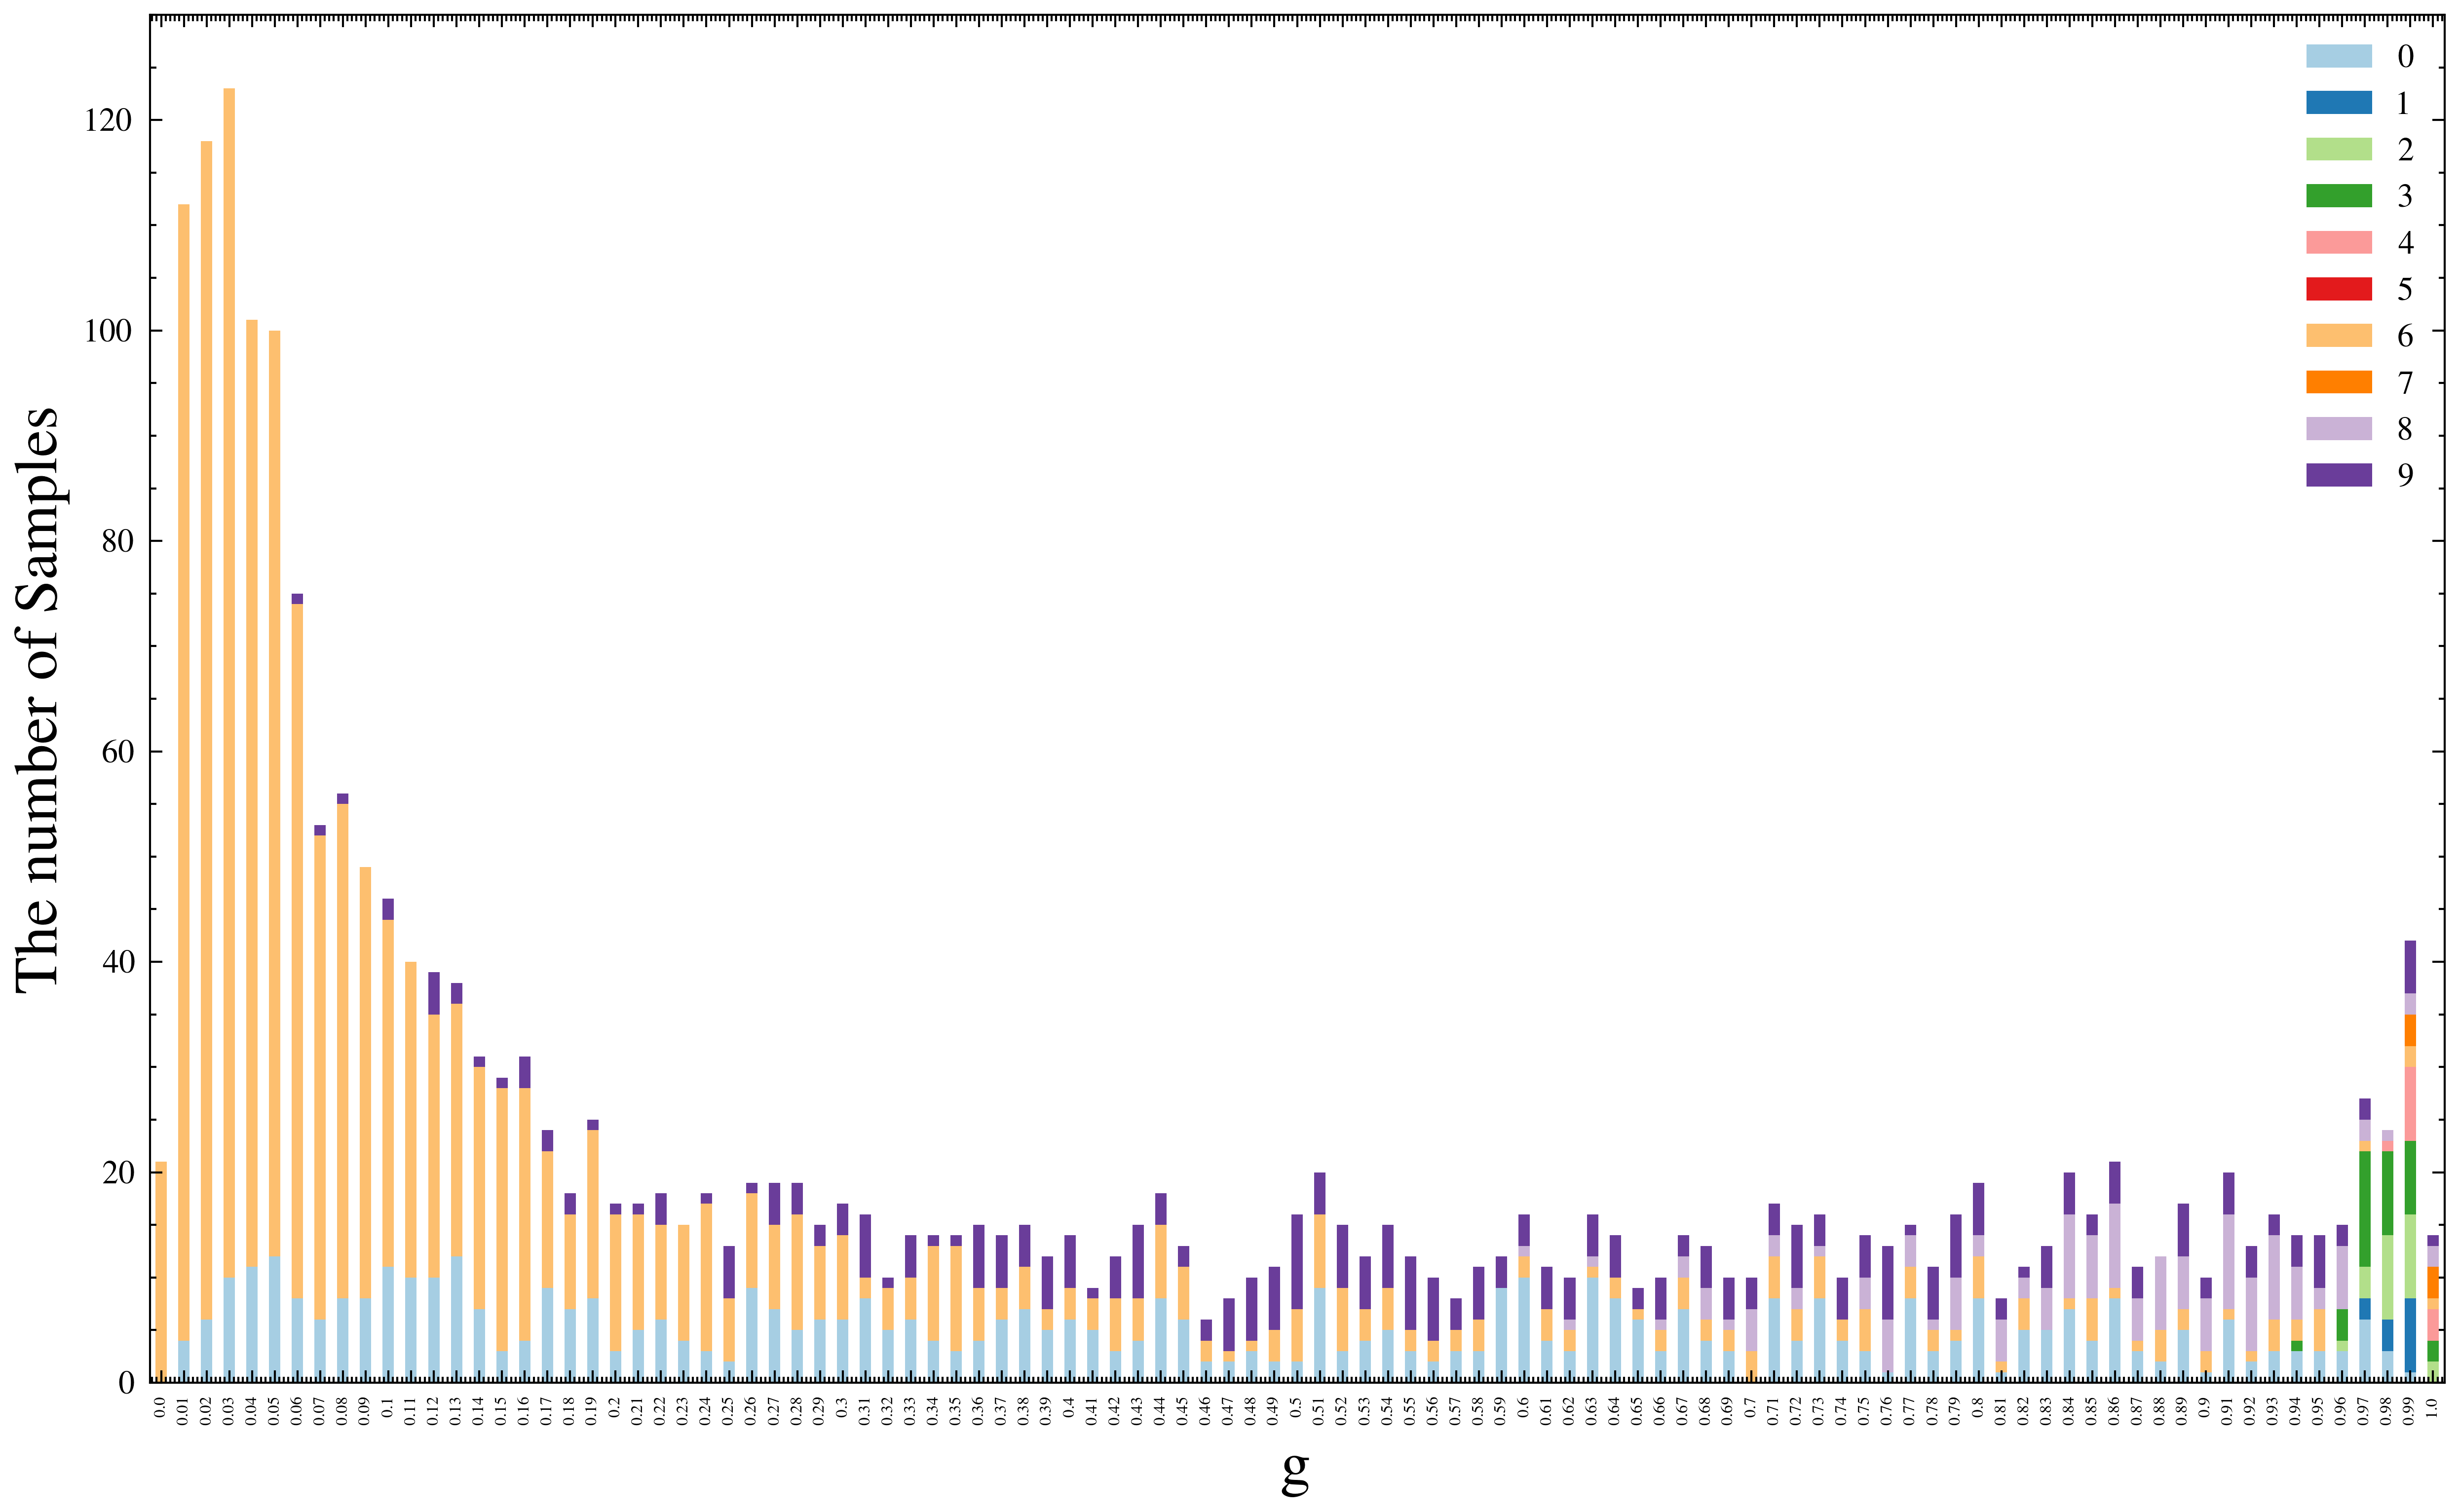

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas
plt.style.use(['science','ieee','retro'])

res_temp = {x:{j:0 for j in range(10)} for x in res_df_fedavg_last_plot["g_norm"].unique()}
for g_target in res_temp.keys():
    for i in range(10):
        res_temp[g_target][i]=((res_df_fedavg_last_plot["label"]==i)&(res_df_fedavg_last_plot["g_norm"]==g_target)).sum()
res_temp_df = pandas.DataFrame(res_temp)
res_temp_df = res_temp_df.T.sort_index(ascending=True)
ax = res_temp_df.plot(kind="bar",stacked=True,figsize=(10,6),color=sns.color_palette("Paired",10))
ax.set_ylabel('The number of Samples')
ax.set_xlabel('g')
ax.set_ylim(0,130)
ax.xaxis.label.set(fontsize=15)
ax.yaxis.label.set(fontsize=15)
ax.xaxis.set_tick_params(labelsize=4)
ax.figure.savefig('../saved/g.pdf',dpi=300)
plt.show()

In [61]:
## FedBalance

In [105]:
from models.resnet_balance import resnet_fedbalance_experimental
model = resnet_fedbalance_experimental(LeNet(10),resnet8(10))
device = torch.device('cuda')
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
client_dis_ = client_infos[0]
client_dis = []
for j in range(10):
    if j in client_dis_:
        client_dis.append(client_dis_[j])
    else:
        client_dis.append(0)
client_dis = torch.Tensor(client_dis)
dist = client_dis / client_dis.sum()  # 个数的比例
cdist = dist#/dist.max()
cdist = cdist.reshape((1, -1)).to(device)
model.to(device)
model.train()
epoch_loss = []
g_all_epochs = {}
for epoch in range(20):
    g_per_epochs = {k:[] for k in range(class_num)}
    batch_loss = []
    for batch_idx, (images, labels) in enumerate(train_dataloader):      
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        log_probs = model(images,cdist)
        log_probs_plot = model.model_global(images)
        probs = torch.softmax(log_probs_plot,-1)
        probs_per = probs.gather(-1, labels.view(-1, 1)).reshape(-1)
        g_norm = torch.abs(1-probs_per)
        for label,g in zip(labels.tolist(),g_norm.tolist()):
            g_per_epochs[label].append(g)
        loss = criterion(log_probs, labels)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    g_all_epochs.update({epoch:g_per_epochs})


In [106]:
res_df_fedbalance = get_df(g_all_epochs)

In [107]:
res_df_fedbalance.columns = ["epoch","label","g"]
res_df_fedbalance_last = res_df_fedbalance[res_df_fedbalance["epoch"]==19]

In [108]:
res_df_fedbalance_last["g_norm"] = res_df_fedbalance_last["g"].round(2)

/home/ict/anaconda3/envs/th/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [109]:
res_df_fedbalance_last_plot = res_df_fedbalance_last.drop(["g","epoch"], axis=1)

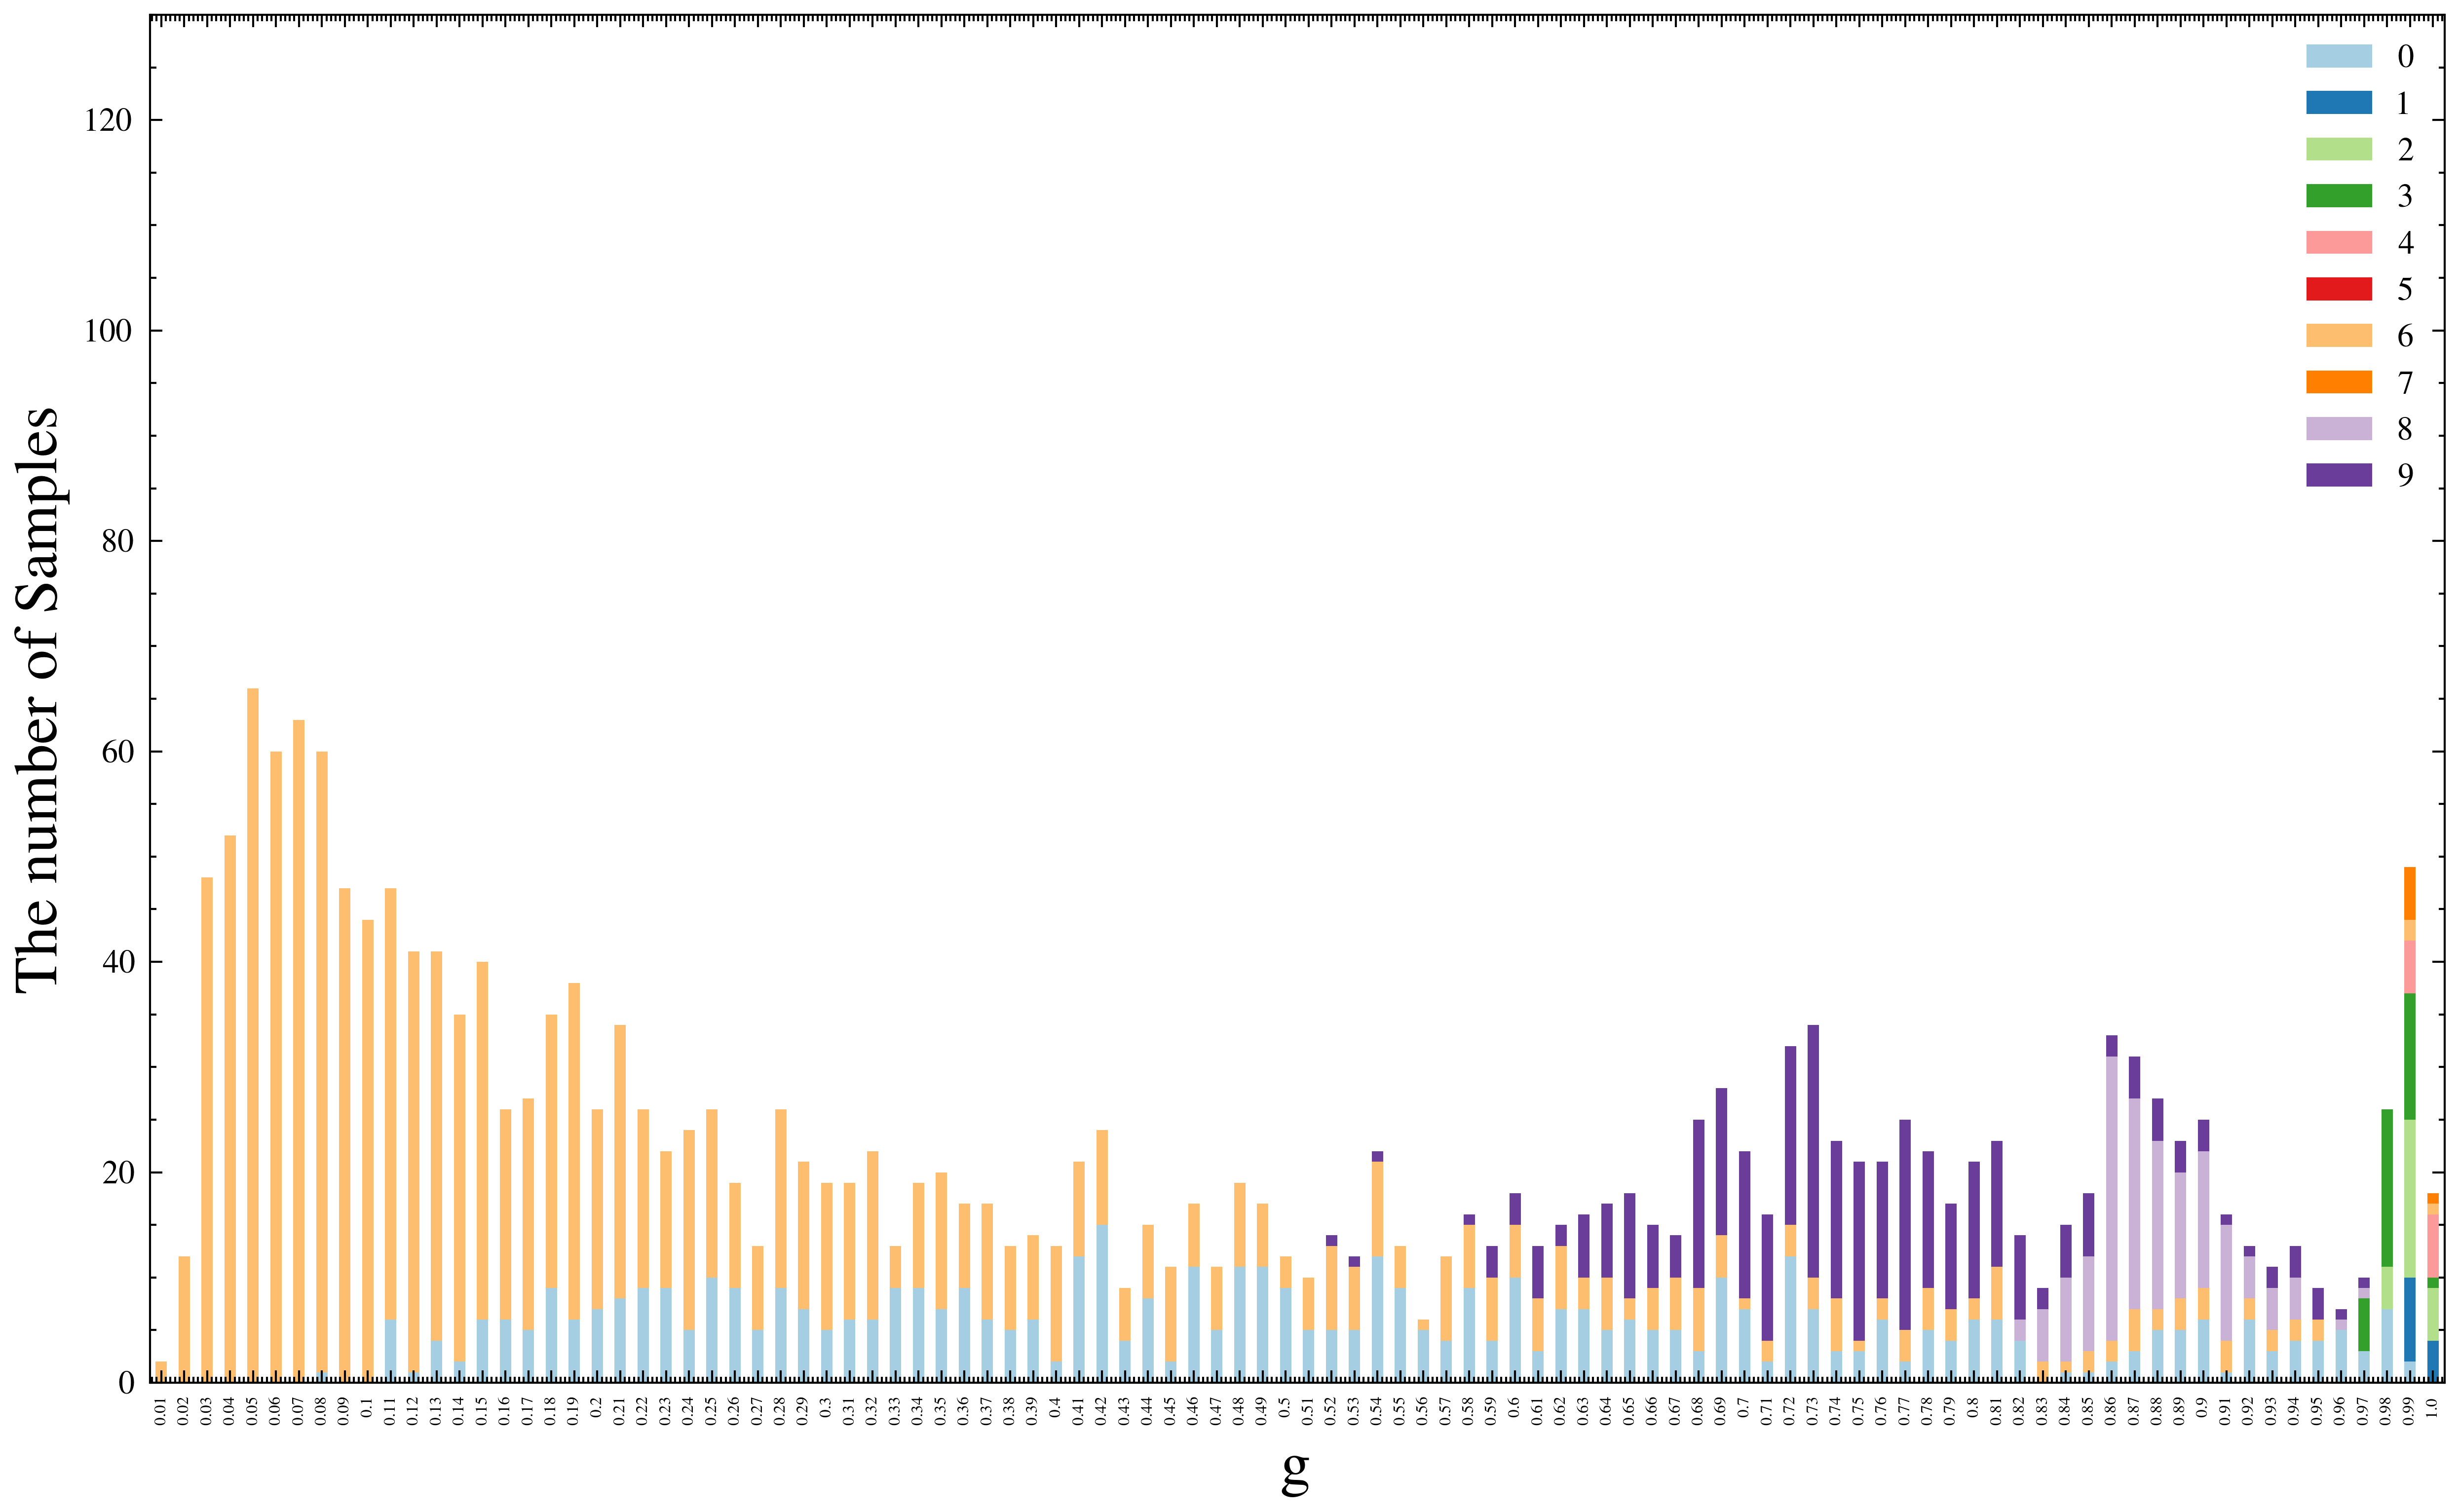

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas
plt.style.use(['science','ieee','retro'])

res_temp = {x:{j:0 for j in range(10)} for x in res_df_fedbalance_last_plot["g_norm"].unique()}
for g_target in res_temp.keys():
    for i in range(10):
        res_temp[g_target][i]=((res_df_fedbalance_last_plot["label"]==i)&(res_df_fedbalance_last_plot["g_norm"]==g_target)).sum()
res_temp_df = pandas.DataFrame(res_temp)
res_temp_df = res_temp_df.T.sort_index(ascending=True)
ax = res_temp_df.plot(kind="bar",stacked=True,figsize=(10,6),color=sns.color_palette("Paired",10))
ax.set_ylabel('The number of Samples')
ax.set_xlabel('g')
ax.set_ylim(0,130)
ax.xaxis.label.set(fontsize=15)
ax.yaxis.label.set(fontsize=15)
ax.xaxis.set_tick_params(labelsize=4)
ax.figure.savefig('../saved/g_.pdf',dpi=300)
plt.show()